## Recap & Goals

In the previous page, we learned how we can vectorize content into *embeddings*. We learned how embeddings are a way to quantify details about content. We also learned how it is possible to use those embeddings to determine how similar content is, as well as find similar content to a query embedding vector.

My primary goal in this page is to expand on implementation details on how we can create a more powerful content recommendation system. This page will be a bit of a hodge-podge of thoughts that I have to improve upon the algorithm I showcased in the previous page.

In [36]:
#% delete

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Learning Rate - Constant or Not?

In the previous page and demo, I specified learning rates $\alpha$ and $\beta$ as constants. But my thought was, what if we get rid of this constraint?

When a new embedding spawns in the content recommendation system, it does not know much about it. The system needs to be able to shift its knowledge of the embedding faster. But how can we achieve that? We can view an embedding vector as a statistical representation of what *we think the conent means*.

### Standard Error of the Mean

What if we use *standard error of the mean (SEM)* to control our learning rate? If the standard error is high, we can have a high learning rate and if the standard error is low, we can have a lower learning rate.

$$
\sigma_{\bar{x}} = \frac{\sigma}{\sqrt{N}}
$$

where,
* $n$ is the number of experiments
* $\sigma$ is the standard deviation, which we will replace with a hyperparameter
* $\sigma_\bar{x}$ is the standard deviation of all of our observations

When an embedding is initially onboarded, there are a total of $0$ experiments on it. Thus,

$$
\sigma_\bar{x} = \frac{\sigma}{\sqrt{0}}
$$

But wait, that's undefined since we are dividing by zero! But looking at its limit,

$$
\lim\limits_{N\to 0} \left( \frac{\sigma}{\sqrt{N}} \right) = \infty
$$

Which makes sense. We have no clue what the correct value for vector is, thus we need to cover an infinite number of standard deviations to capture the entire range of potential values. We can fix this by adding a positive bias to the fraction:

$$
\sigma_\bar{x} = \frac{\sigma}{\sqrt{N} + \epsilon}
$$

Where $\epsilon$ is a tiny positive number which has the job of ensuring we can never divide by zero.

But how can we use this to control our learning rate? We know that as $n$ increases, the *population standard deviation, $\sigma_\bar{x}$ will decrease, reducing our learning rate. Thus, we can control our learning rate from the standard error. Fully put together, this turns into:

$$
\operatorname{learning-rate}(N) = \max \left( \alpha_\text{min}, \frac{\alpha}{\sqrt{N} + \epsilon} \right)
$$

Let's see how this behaves!

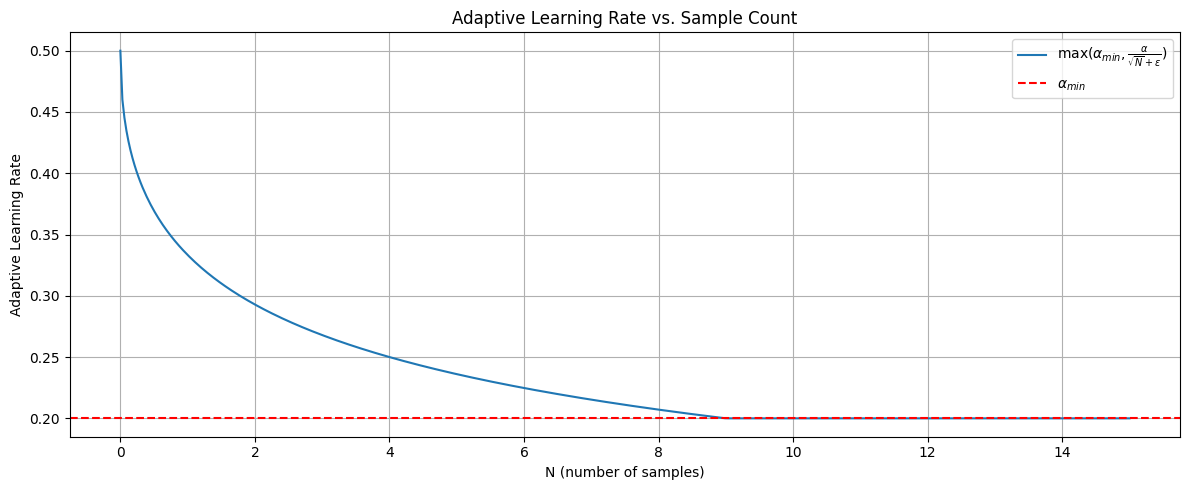

alpha = 1.0, alpha_min = 0.2, epsilon = 2


In [33]:
#% hidecode

# Params
alpha = 1.0
alpha_min = 0.2
epsilon = 2

# N values (sample count)
N = np.linspace(0, 15, 500)

# Compute adaptive alpha
adaptive_alpha = np.maximum(alpha_min, alpha / (np.sqrt(N) + epsilon))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(N, adaptive_alpha, label=r'$\max(\alpha_{min}, \frac{\alpha}{\sqrt{N} + \epsilon})$')
plt.axhline(alpha_min, color='red', linestyle='--', label=r'$\alpha_{min}$')
plt.xlabel('N (number of samples)')
plt.ylabel('Adaptive Learning Rate')
plt.title('Adaptive Learning Rate vs. Sample Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'alpha = {alpha}, alpha_min = {alpha_min}, epsilon = {epsilon}')

Notice how we $\max(\alpha_\text{min}, \cdots)$ ensures our learning rate never goes to zero so we our recommendations system can keep learning? By using this, the first few experiments the user does will lead to the system learning much more, helping it achieve steady state faster!

### Magnitude-Based Learning Rate

The magnitude of an embedding vector tends to indicate the strength of the embedding. A higher magnitude means the embedding fitted much stronger to its meaning. Whereas, an embedding with a low magnitude (close to zero) has a very weak fit to its meaning.

We can first start calculating the direction and magnitudes of the vectors:

$$
\|\vec{V}\| = \sqrt{\sum\limits_{i=1}^n{\vec{V}_i^2}}
$$

We can use a logarithm to keep our system more sensitive to low magnitudes, and less sensitive as the magnitudes approach infinity.

$$
\operatorname{learning-rate}(\vec{V}) = \frac{\alpha}{\log{\|\vec{V}\|}}
$$

This will fail if $\|V\| = 0$, so we can fix that by adding a bias.

$$
\operatorname{learning-rate}(\vec{V}) = \frac{\alpha}{\sqrt{\|\vec{V}\|} + \gamma}
$$

And we want to maintain a minimum learning rate so we keep learning, even if our embedding has seen a ton of experiments.

$$
\operatorname{learning-rate}(\vec{V}) = \min\left(\alpha_\min, \frac{\alpha}{\sqrt{\|\vec{V}\|} + \gamma} \right)
$$

Let's see how this behaves:

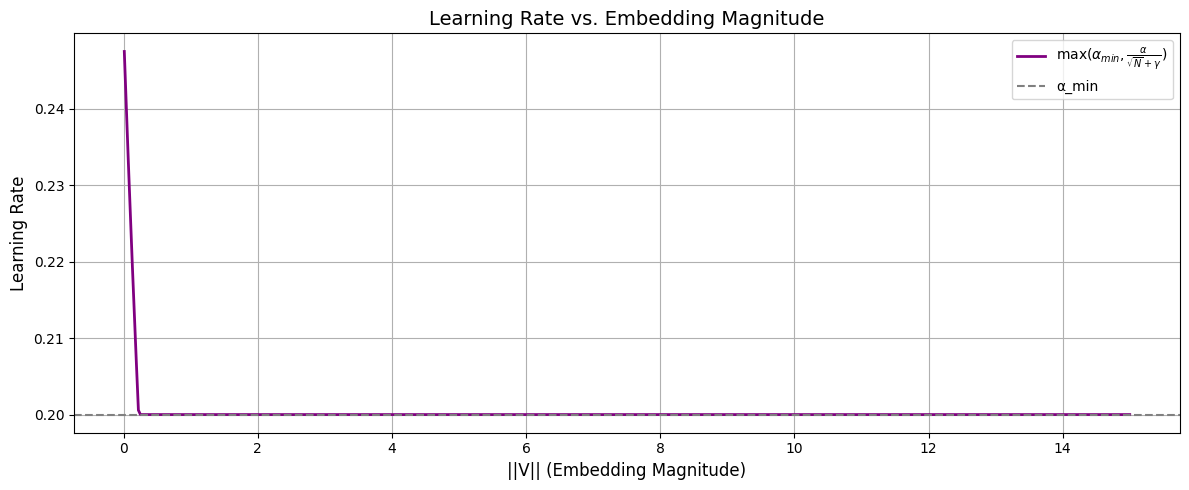

alpha=1.0 alpha_min=0.2 gamma=2.0


In [43]:
#% hidecode

# Hyperparameters
alpha = 1.0        # base learning rate (max)
alpha_min = 0.2   # min learning rate
gamma = 2.0        # smoothing offset to prevent log(0)

# Magnitude range (simulate embedding vector norms)
magnitudes = np.linspace(0.01, 15, 500)

# Learning rate formula
learning_rates = np.maximum(
    alpha_min,
    alpha / (np.sqrt(magnitudes) + gamma)
)

# Plot it
plt.figure(figsize=(12, 5))
plt.plot(magnitudes, learning_rates, color='purple', linewidth=2, label=r'$\max(\alpha_{min}, \frac{\alpha}{\sqrt{N} + \gamma})$')
plt.title('Learning Rate vs. Embedding Magnitude', fontsize=14)
plt.xlabel('||V|| (Embedding Magnitude)', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.grid(True)
plt.axhline(alpha_min, color='gray', linestyle='--', label='α_min')
plt.legend()
plt.tight_layout()
plt.show()

print(f'alpha={alpha} alpha_min={alpha_min} gamma={gamma}')

### SEM and Magnitude-Based Boosting

In both functions, I used $\frac{\operatorname{constant}}{\sqrt{x}}$ since it decays at a gradual rate and looks nice in these visuals. You can use a different decay function per what works with your data and testing.

### Using both Standard Error (SEM) and Magnitude

We can combine both approaches. By doing so, we essentially boost the learning rate if our embeddings are weak.

$$
\operatorname{learning-rate}(N, \vec{V}) = \max{\left(
\alpha_\min, \frac\alpha{\sqrt{N}+\epsilon} + \frac{\beta}{\sqrt{\|\vec{V}\|} + \gamma}
\right)}
$$

With this function, if number of experiments ($N$) is low OR the magnitude of the vector is low OR both are true, the the learning rate will be boosted. Additionally, we still keep a minumum learning rate of $\alpha_\min$.

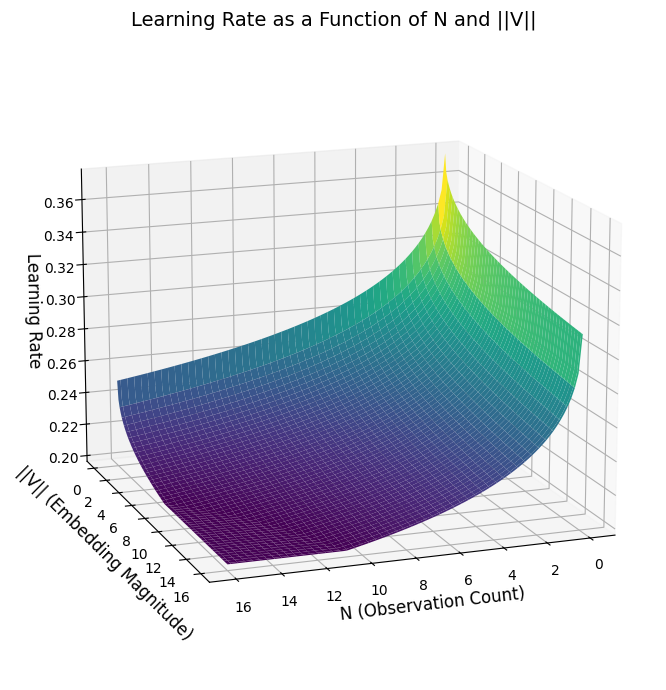

alpha = 1.0 beta = 0.5 alpha_min = 0.2 epsilon = 4.0 gamma = 4.0


In [35]:
#% hidecode

# Hyperparameters
alpha = 1.0
beta = 0.5
alpha_min = 0.2
epsilon = 4.0
gamma = 4.0

# Create grid
N_vals = np.linspace(0, 16, 100)
V_mags = np.linspace(0, 16, 100)
N_grid, V_grid = np.meshgrid(N_vals, V_mags)

# Compute learning rates
lr_values = np.maximum(
    alpha_min,
    alpha / (np.sqrt(N_grid) + epsilon) + beta / (np.sqrt(V_grid) + gamma)
)

# Plot
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(N_grid, V_grid, lr_values, cmap='viridis', edgecolor='none')

ax.set_title('Learning Rate as a Function of N and ||V||', fontsize=14)
ax.set_xlabel('N (Observation Count)', fontsize=12)
ax.set_ylabel('||V|| (Embedding Magnitude)', fontsize=12)
ax.set_zlabel('Learning Rate', fontsize=12)
ax.view_init(elev=15, azim=70)  # Tilt it for drama

plt.tight_layout()
plt.show()

print(f'alpha = {alpha} beta = {beta} alpha_min = {alpha_min} epsilon = {epsilon} gamma = {gamma}')

## Keeping Recommendations Interesting

### Serving Different Content

Assuming the content enrolled in the system stays constant and consistent, if we query similarity for a user multiple times, we will get the same result. No one wants to see the exact same content and recommendations over and over again. Additionally, we want to create opportunities for the algorithm to recommend something different from the user's typical choices, leading to high higher value learning!

$$
\hat{V}_\text{noisy} = \hat{V}_\text{user} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma_{\text{noise}}^2)
$$

Where,
* $\epsilon$ is a noise vector
* Each element $\epsilon_i \sim \quad \epsilon \sim \mathcal{N}(0, \sigma_{\text{noise}}^2)$

The goal of the random noise is to add enough perturbation to the algorithm to keep its recommendations different, yet relevant. This means, we need to be careful of how much noise we add.

## Some Possible Issues

### People's Interests are not Simple

People's interests are multimodal. When it comes to movies, sometimes I enjoy watching comedies. Other times, I like watching dramas. This algorithm currently has no flexibility to effectively carry this concern.

I'm not sure if this can be alleviated by using a larger embedding.

### Biases

If using this technique fully unsupervised, it is possible for biases to develop since it is hard to curate human feedback without manual effort.

### (Human) Feedback

Achieving human feedback is a hard problem. How do you know if their feedback is negative, positive or neutral? What if it's something in the middle? A lot of studies into HCI (human-computer interactions) would be necesssary to optimize feedback methods to appropriately understand users.

As an example, perhaps a user may "like" or "dislike" content. That's direct feedback that could be used. But you have extra variables such as the amount of time the user viewed the content or if they interacted with it.

## Sources

* [Wikipedia: Standard Error](https://en.wikipedia.org/wiki/Standard_error)